In [1]:
#Installing Necessary Packages for Analysis
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=24e433bb4f65fa75379fa67bcbdf9c0003d75bd64f916013c4da07e3acc786d0
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
#Importing Required Libraries

from pyspark.sql import SparkSession
import xgboost as xgb
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

In [3]:
#Creating a Spark Session
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()
df = spark.read.csv("APPLE.csv", header=True, inferSchema=True)
df.show()

+----------+-----------+-----------+-----------+-----------+---------+-------+
|      Date|       Open|       High|        Low|      Close|   Volume|Company|
+----------+-----------+-----------+-----------+-----------+---------+-------+
|04-01-2020|102.6100006|105.3700027|      102.0|105.3499985| 67649400|  APPLE|
|05-01-2020|     105.75|105.8499985|102.4100037|102.7099991| 55791000|  APPLE|
|06-01-2020|100.5599976|102.3700027|99.87000275|100.6999969| 68457400|  APPLE|
|07-01-2020|98.68000031|100.1299973|96.43000031|96.44999695| 81094400|  APPLE|
|08-01-2020|98.55000305|99.11000061|96.76000214|96.95999908| 70798000|  APPLE|
|11-01-2020|98.97000122|99.05999756|97.33999634|98.52999878| 49739400|  APPLE|
|12-01-2020|100.5500031|100.6900024|98.83999634|99.95999908| 49154200|  APPLE|
|13-01-2020|100.3199997|101.1900024|97.30000305|97.38999939| 62439600|  APPLE|
|14-01-2020|97.95999908|100.4800034|95.73999786|99.51999664| 63170100|  APPLE|
|15-01-2020|96.19999695|97.70999908|95.36000061|97.1

## **XGBooster Regression Model**

In [5]:
# Select the feature columns you want to use for prediction
X = df.select(["Open", "High", "Low", "Close", "Volume"]).toPandas()  # Convert to Pandas DataFrame
y = df.select("Close").toPandas()["Close"]  # Target variable (for example, predicting 'Close')

# Train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## **Scaling Features**

In [6]:
# Step 1: Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=["Open", "High", "Low", "Close", "Volume"], outputCol="features")
df_assembled = assembler.transform(df)

# Step 2: Apply MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_assembled)
scaled_df = scaler_model.transform(df_assembled)

# Show the scaled data
scaled_df.select("scaledFeatures").show()

+--------------------+
|      scaledFeatures|
+--------------------+
|[0.05371901306316...|
|[0.06709551272700...|
|[0.04498593354716...|
|[0.03697708389015...|
|[0.03642329133061...|
|[0.03821249720747...|
|[0.04494335665180...|
|[0.04396353468025...|
|[0.03390985521136...|
|[0.02641218884229...|
|[0.03582688937166...|
|[0.02172615950803...|
|[0.03007581943743...|
|[0.03676406922675...|
|[0.04907556053906...|
|[0.04230212458277...|
|[0.02573060054596...|
|[0.01614552729925...|
|[0.02040555985334...|
|[0.02756241582223...|
+--------------------+
only showing top 20 rows



##**ARIMA Modelling**

In [13]:
# Convert Spark DataFrame to Pandas if not already done
df_pandas = df.select("Close").toPandas()  # Assuming 'Close' is the column of interest

# Step 1: Fit ARIMA model (using the 'Close' column for time series modeling)
model = ARIMA(df_pandas['Close'], order=(5, 1, 0))  # ARIMA order can be adjusted
model_fit = model.fit()

# Step 2: Display the summary of the model
print(model_fit.summary())

# Step 3: Forecast the next 10 time steps
predictions = model_fit.forecast(steps=10)
print("Predicted values for the next 10 time steps:")
print(predictions)

# Step 4: Simulate actual values for comparison (for illustration purposes)
# In practice, you should replace this with actual future data
np.random.seed(42)  # For reproducibility
simulated_actual_values = predictions + np.random.normal(0, 1, size=10)  # Add some noise

# Step 5: Calculate the R-squared score
r2 = r2_score(simulated_actual_values, predictions)

print("\n\n")

print(f"R-Squared: {r2}")

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1069
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2894.445
Date:                Sun, 13 Oct 2024   AIC                           5800.891
Time:                        12:26:54   BIC                           5830.732
Sample:                             0   HQIC                          5812.196
                               - 1069                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2114      0.014    -14.793      0.000      -0.239      -0.183
ar.L2          0.0052      0.012      0.426      0.670      -0.019       0.029
ar.L3          0.0229      0.017      1.374      0.1

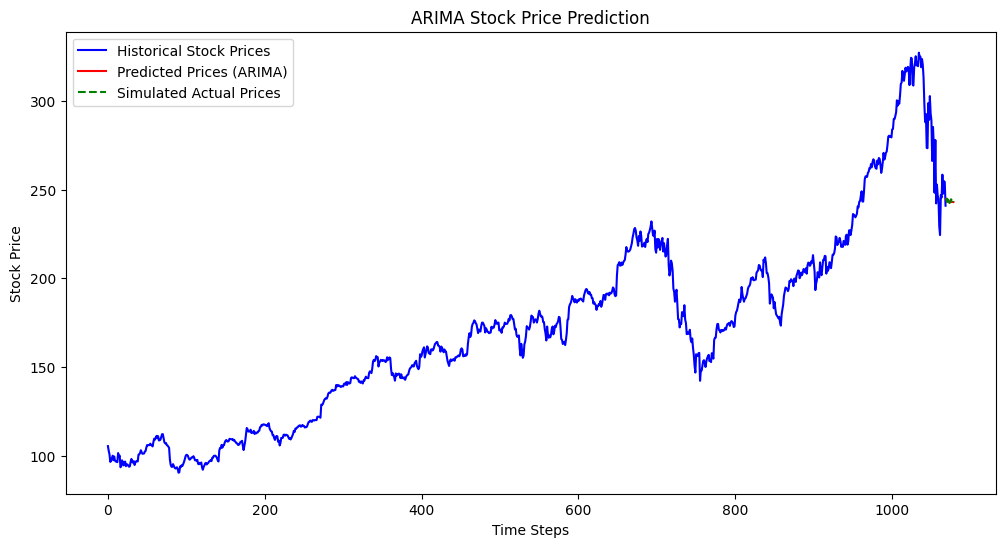

In [8]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plot historical prices
plt.plot(df_pandas['Close'], color='blue', label='Historical Stock Prices')

# Create x-values for predicted prices
# Start from the end of historical data
x_values_predictions = np.arange(len(df_pandas['Close']), len(df_pandas['Close']) + 10)
# Plot predicted prices
plt.plot(x_values_predictions, predictions, color='red', label='Predicted Prices (ARIMA)')

# Plot simulated actual prices
plt.plot(x_values_predictions, simulated_actual_values, color='green', linestyle='dashed', label='Simulated Actual Prices')

plt.title('ARIMA Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

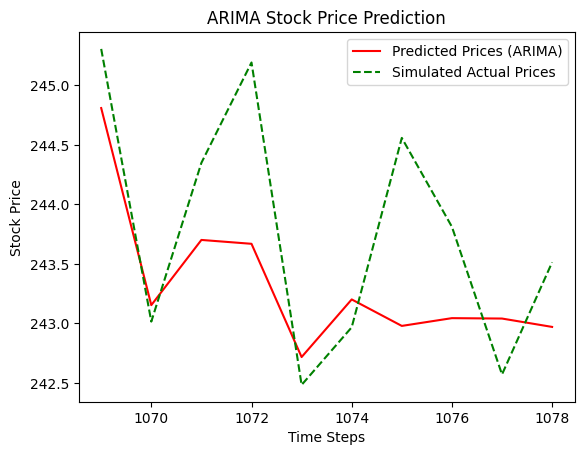

In [9]:
# Create x-values for predicted prices
# Start from the end of historical data
x_values_predictions = np.arange(len(df_pandas['Close']), len(df_pandas['Close']) + 10)
# Plot predicted prices
plt.plot(x_values_predictions, predictions, color='red', label='Predicted Prices (ARIMA)')

# Plot simulated actual prices
plt.plot(x_values_predictions, simulated_actual_values, color='green', linestyle='dashed', label='Simulated Actual Prices')

plt.title('ARIMA Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

##**LSTM (Long Short Term Memory) Modelling**

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess your data (assuming df contains a 'Close' column for stock prices)
data = df.select("Close").toPandas()["Close"].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences of 60 time steps (this is an example, you can change the number)
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # 60 time steps of data
        y.append(data[i, 0])  # The target value (next time step)
    return np.array(X), np.array(y)

# Create the sequences for training
X, y = create_sequences(scaled_data)

# Reshape X to be 3-dimensional (samples, time steps, features) as required by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))  # Add a fully connected layer with 25 units
model.add(Dense(1))   # Final layer with one output

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10)

# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"LSTM R-Squared: {r2}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0521
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0066
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0025
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0011
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 8.3974e-04
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 8.9173e-04
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.2455e-04
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.4146e-04
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.5685e-04
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.1441e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM R-Squared: 0.9100835914237888


In [11]:
# Load and preprocess your data (assuming df contains a 'Close' column for stock prices)
data = df.select("Close").toPandas()["Close"].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences of 60 time steps (this is an example, you can change the number)
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # 60 time steps of data
        y.append(data[i, 0])  # The target value (next time step)
    return np.array(X), np.array(y)

# Create the sequences for training
X, y = create_sequences(scaled_data)

# Reshape X to be 3-dimensional (samples, time steps, features) as required by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))  # Add a fully connected layer with 25 units
model.add(Dense(1))   # Final layer with one output

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10)

# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Prepare actual values for comparison
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0643
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0051
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0026
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0014
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 7.9584e-04
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 6.7923e-04
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.0394e-04
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.9294e-04
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.4234e-04
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 7.0878e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


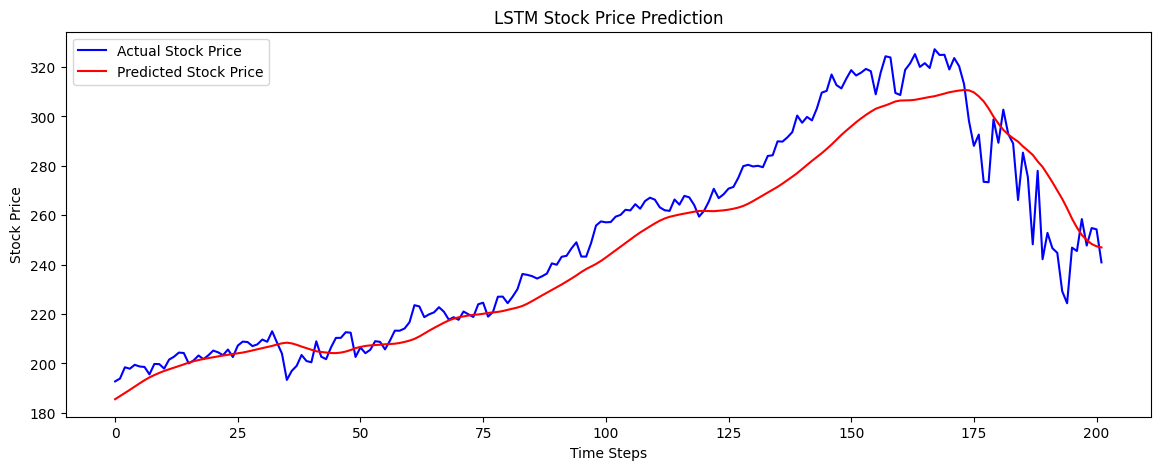

In [12]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(actual_values, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()